In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
boston.keys()
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['target'] = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

The dependent variable, MEDV, is the median value of owner-occupied homes, in the $1000. 

### Linear Regression Assumptions
Since we'd like to use Linear Regression to make *inference*, rather than simply make *predictions*, we must ensure that the following assumptions hold:
1. Linear and additive relationship between independent and dependent variables (logically implies no multicollinearity)
2. Residuals are normally distributed
3. Homoskedascitiy: Residual variance constant with respect to each level of each independent varaibles and with respect to the predictions
4. Residuals are independent of one another
5. (Honorable Mention): Rule of thumb that there should be 20 examples per feature in the dataset.

### Which Assumptions Hold, Which Must We Test, and How Do We Test Them? 
1. Must check. Lack of pattern in residual vs predicted value plot. Lack of interaction effects found in interaction plots. Pearson correlation < 0.8 between independent variables.
2. Must check. Points consistently close to the diagonal line of the quantile quantile plot, and absolute value of skew is < 1
3. Must check. Variance of residuals are relatively consistent with respect to in predicted value and independent variable values
4. Holds. Not dealing with time series data, so we can reason that this is not an issue. 
5. Holds. We have 506 examples with 13 features, so this rule of thumb is met. 

### A Note About Multicollinearity
The contrapositive of the statement   
"The dependent and independent variables have a linear and additive relationship **implies** that there is no multicollinearity among independent variables."  
Is  
"Existence of multicollinearity among independent variables **implies** that the dependent and independent variables do not have a linear and additive relationship."  
In fact, lack of multicollinearity is so important to inference using regression that it is often listed as a separate assumption. Therefore, before running any regression analysis we'll check for multicollinearity by using the Pearson correlation coefficient.

### A Note About Skew
QQ plots will be used to determine the cause of deviations from normality, and Pandas' skew() function will be used to determine the level of skew (if any).  
A rule of thumb is that abs(skew()) taking values on [0, 0.5], [0.5, 1], [1, infinity] is approximately symmetric, moderately skewed, and severely skewed. 

In [3]:
def plot_residuals(results):
    '''
    Makes graphs that help us test assumptions 1, 2, and 3
    '''
    fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
    sns.scatterplot(x=results.fittedvalues, y=results.resid, ax=ax[0]).set(xlabel='Predicted Values', ylabel='Residuals');
    ax[0].axhline(0, color='r')
    sm.qqplot(results.resid, fit=True, line='45', ax=ax[1]);
    ax[1].set_title('Skew: {}'.format(round(results.resid.skew(),3)));

### A Quick Look At the Dependent Variable

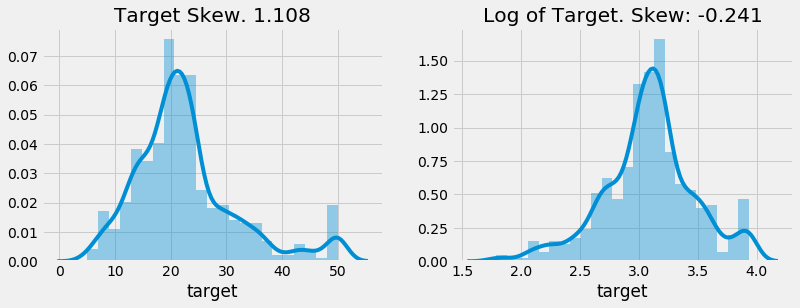

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
sns.distplot(data['target'], ax=ax[0]).set_title('Target Skew. {}'.format(round(data['target'].skew(), 3)));
sns.distplot(np.log1p(data['target']), ax=ax[1]).set_title('Log of Target. Skew: {}'.format(round(np.log1p(data['target']).skew(), 3)));

So our target variable is severely right skewed, and is rendered approximately normal by the log transformation. Also note the spike in values at 50. We'll leave the target as is for now, but we'll keep this in mind. 

### Ranking of Predictors and Multicollinearity Detection

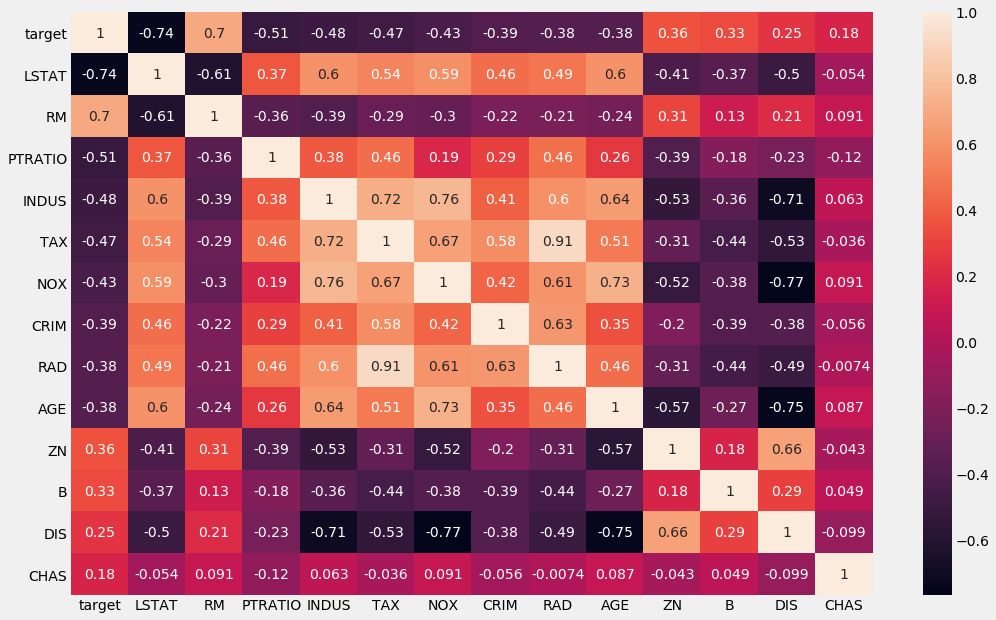

In [5]:
corr_order = abs(data.corr()['target']).sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(data[corr_order].corr(), annot=True);

The relationship between TAX and RAD (0.91 correlation) is the only one that we consider to be severely multicollinear.

The variables most highly correlated with the target:
- RM: average number of rooms per dwelling
- LSTAT: % lower status of the population

## Regression Of The Target with LSTAT

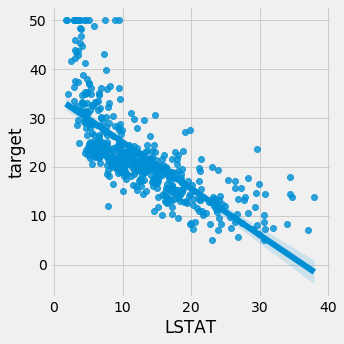

In [6]:
sns.lmplot(x='LSTAT', y='target', data=data, order=1);

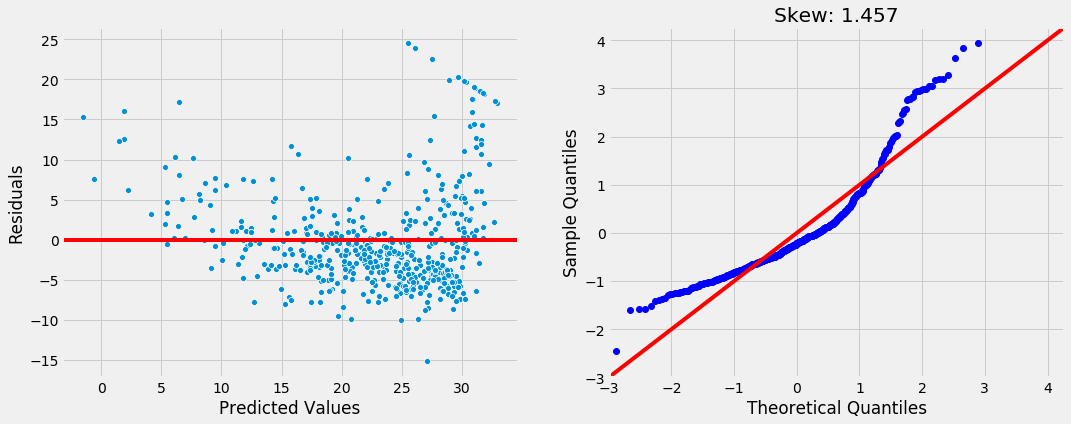

In [7]:
X = sm.add_constant(data['LSTAT'])
y = data['target']
results = sm.OLS(y, X).fit()
plot_residuals(results)

The residuals are severely skewed, and we have a bow shaped pattern. This points to a nonlinear relationship.

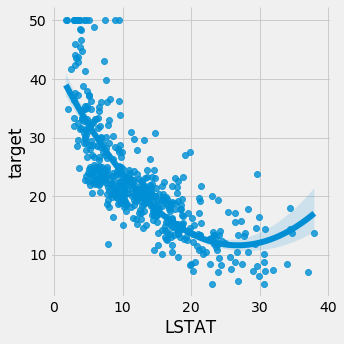

In [8]:
sns.lmplot(x='LSTAT', y='target', data=data, order=2);

First we consider if LSTAT has a quadratic relationship with the target. This quadratic line fits the data with LSTAT on the interval [5, 25] fairly well. However, we can rely on intuition to say that this is not the correct relationship. This plot claims that median housing price decreases as the % lower status increases, until the LSTAT reaches 25% in which case the median housing price begins to *increase*.  
We reason that this relationship is monotonically nonincreasing, so next we'll try transforming it via a monotonic nonlinear function, namely the natural logarithm. 

### Logarithms of Independent Variables/Predictors
Using the log transform of a predictor does not jeopardize interpretability, but it does complicate it. Here's a quote from a [UPenn graduate level statistics course](http://www-stat.wharton.upenn.edu/~stine/stat621/handouts/LogsInRegression.pdf) that explains how we interpret the effects of log-transformed predictors:  
  
"when we use a log scale for the predictor, we are saying that a given percentage change in the predictor has the same impact on the response. Everytime we increase the predictor by, say 20%, we expect the same change on average in the response."  

### Logarithms of *Percentage* Valued Predictors
The interpretation described in the above quote becomes even more complicated when we are taking the log transform of a predictor that represents a percentage, in this case the percentage of the population with lower status. Here we must make a distinction between two types of changes in percentage values:  
* Percentage point change: a proportion changing from 4% to 5% is a **1** percentage point change
* Percentage change: a proportion changing from 4% to 5% is a **25** percent change  
  
Before the LSTAT was log transformed, its linear regression coefficent would have represented the linear effects of a *percentage point change* on the target variable. After the log transformation, its regression coefficent represents the linear effects of a *percentage change* on the target variable. A subtle but important difference.

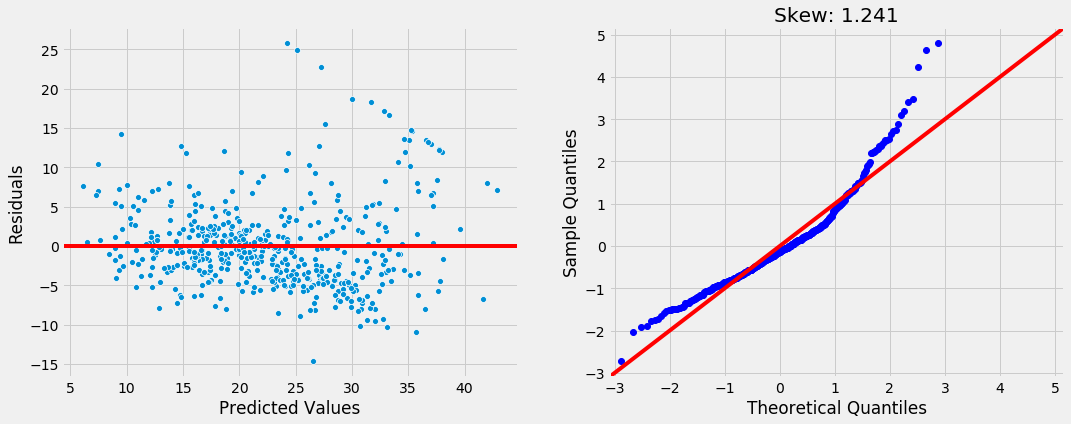

In [9]:
data['LSTAT_log'] = np.log1p(data['LSTAT'])
X = sm.add_constant(data['LSTAT_log'])
results = sm.OLS(y, X).fit()
plot_residuals(results)

The residuals are now more normal than before, but are still severely skewed. 

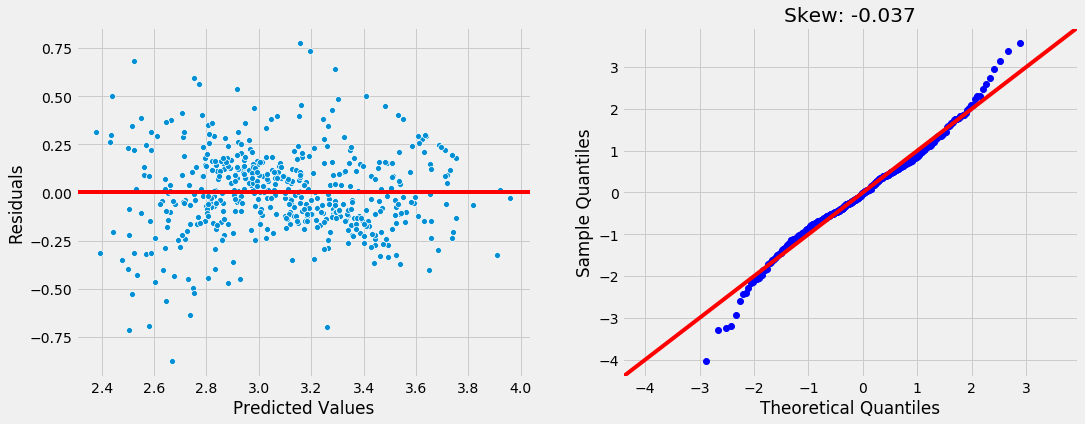

In [10]:
data['target_log'] = np.log1p(data['target'])
X = sm.add_constant(data['LSTAT_log'])
results = sm.OLS(data['target_log'], X).fit()
plot_residuals(results)

* Residual vs Predicted plot: modest increase in variance as the predicted value becomes smaller, but not a significant enough increase to call heteroscedastic.
* QQ plot: We still have some deviation from normality at the margins, but the residuals are approximately normal. 
  
### Logarithms of Dependent Variables
Just like log transforming a variable effected (but did not jeopardize) interpretibility, so does log transforming the dependent variable. Regression with a log transformed dependent variable means that we are now studying the effects that the independent variable(s) have on the percent change in the dependent variable.  

Taking the log transform of variables that represent value/money is fairly common. This is because it is generally accepted that changes in money are multiplicative, rather than additive. For example, an increase from \$1000 to \$1100 is more similar to an increase from \$10,000 to \$11,000 than it is to an increase from \$10,000 to \$10,100.  

Taking the logarithm of a monetary value enforces this assumption that the effects that yield an increase from \$1000 to \$1100 are the same effects that yield an increase from \$10,000 to \$11,000. 

Now that we've justified taking the log of the target and of LSTAT, let's accept these changes and move on to RM.

In [11]:
data = data.drop(columns=['LSTAT', 'target'])

## Regression Of The Target with RM
How does the average number of rooms per house effect the *percentage* change in median house values?

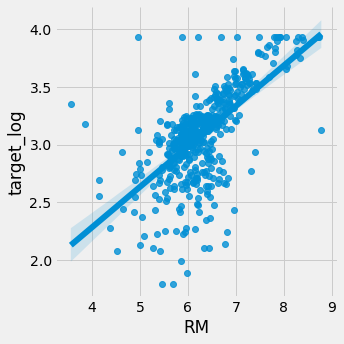

In [12]:
sns.lmplot(x='RM', y='target_log', data=data, order=1);

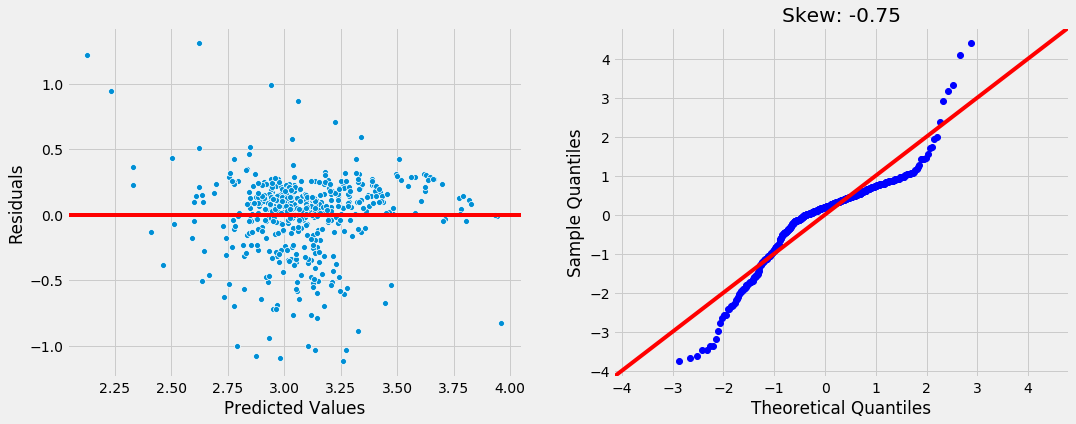

In [13]:
X = sm.add_constant(data['RM'])
results = sm.OLS(data['target_log'], X).fit()
plot_residuals(results)

* Residual vs Predicted plot: Increase in variance as predicted value decreases. May not be Homoscedastic, although the increase in variance is mostly due to the 3 datapoints nearest to the top left corner, so we can't quite say that it is Heteroscedastic.
* QQ plot: Deviations from normality, somewhat skewed. 
  
### (You Guessed It) We'll Try Log Transform of RM
How does the *percentage change* of the average number of rooms per house effect the *percentage change* in median house values?

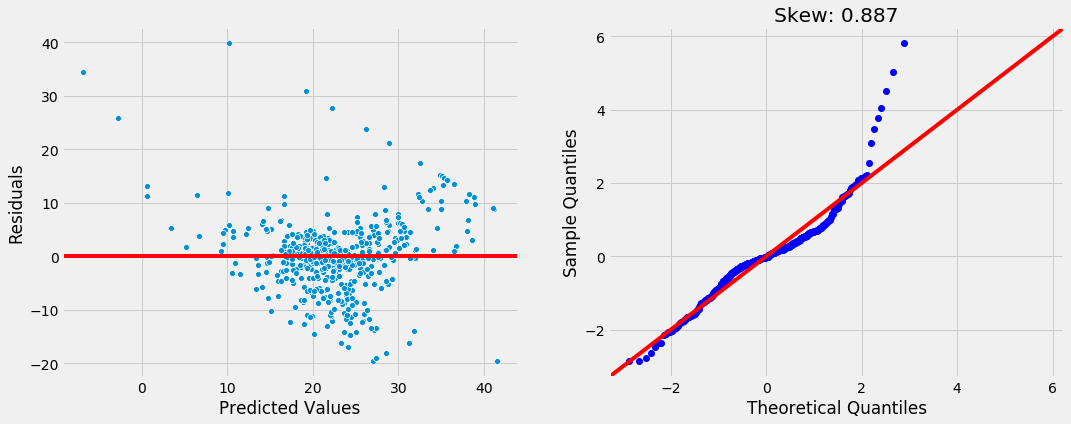

In [14]:
data['RM_log'] = np.log1p(data['RM'])
X = sm.add_constant(data['RM_log'])
results = sm.OLS(y, X).fit()
plot_residuals(results)

The 7 outliers on the right side of the distribution are greatly contributing to the skew, but without more information about where the data came from we cannot safely remove these outliers.  

I was expecting the log transform of RM to be preferable - I reasoned that an increase in the number of rooms from 3 to 4 would be a more significant to the percentage increase in price than, say a increase from 7 to 8.  

All things considered, we should go where the qqplots and skew values are telling us: we'll use the non-transformed RM. Note that its residuals have a skew of -0.75, so it is considered somewhat, but not severely, skewed. We reason that this is not a violation of the assumption of normality of residuals. 

In [15]:
data = data.drop(columns=['RM_log'])

# Inference With LSTAT and RM

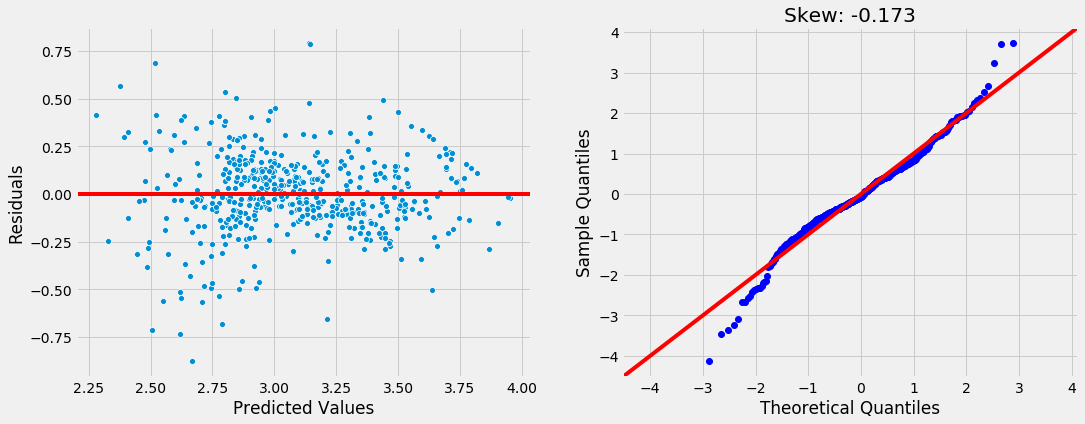

In [16]:
X = sm.add_constant(data[['LSTAT_log','RM']])
results = sm.OLS(data['target_log'], X).fit()
plot_residuals(results)

We see modest heteroscedasticity: the variance descreases as the predicted values increases. This could be addressed by taking different transformations of the variables, but this would sacrifice the ease of interpretability. We'll assume that this is sufficiently homoscedastic, but this assumption should be challenged in future work. 

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             target_log   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     584.5
Date:                Thu, 05 Mar 2020   Prob (F-statistic):          6.31e-132
Time:                        23:22:08   Log-Likelihood:                 66.825
No. Observations:                 506   AIC:                            -127.7
Df Residuals:                     503   BIC:                            -115.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8126      0.158     24.198      0.000       3.503       4.122
LSTAT_log     -0.5179      0.023    -22.130      0.000      -0.564      -0.472
RM             0.0883      0.018      4.918      0.000       0.053       0.124
==============================================================================
Omnibus:                       26.113   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.188
Skew:                          -0.173   Prob(JB):                     9.46e-16
Kurtosis:                       4.778   Cond. No.                         116.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To interpret these coefficents we follow the rules for interpretation of log-transformed regression found [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/). The rules of interpretation can be elegantly derived from the linear regression equation, specifically by differentiating with respect to the variable of interest and applying certain exponent rules. I refer the reader to the link for a more detailed explanation. 

In [18]:
print((1.01**-0.564 - 1)*100)
print((1.01**-0.472 - 1)*100)

-0.5596268820784012
-0.46855445883712266


In [19]:
print((np.exp(0.053)-1)*100)
print((np.exp(0.124)-1)*100)

5.4429645119356
13.201587099917521


# Inferences
### Are The Variables Statistically Significant? (P-values)
* Even given the effects due to the logarithm of the percentage of the population that is lower status, the average number of rooms has a statistically significant effect on log of the median house value.
* Even given the effects due to the average number of rooms, the logarithm of the percentage of the population that is lower status has a statistically significant effect on log of the median house value.
  
### What Are The Effects of The Variables? (Confidence Intervals)
* We are 95% confident that, for a fixed percentage of the population that is lower status, an increase of 1 in the average number of rooms per house effects between a 5.44 and 13.20 **percent increase** in the median house value. 
* We are 95% confident that, for a fixed average number of rooms per house, an increase of 1 **percent** in the **percentage** of the population that is lower status effects between a 0.47 and 0.56 **percentage decrease** in the median house value. 